# Explanation and Interpretation
Note that a lot of this code has been based on the practical session of the course.

In [1]:
import torch
from torchvision import datasets, transforms, models
import torchvision
from torch.optim import Adam, SGD

from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

import os
import time

import re

import pandas as pd
import numpy as np

from PIL import Image

from torch import nn, optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import pickle
import itertools
import copy
import seaborn as sns

from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials

In [2]:
## settings
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 15
BATCH_SIZE = 15
NUM_EPOCHS = 20
LEARNING_RATE = 0.00005
OPTIMIZER = "Adam"

In [3]:
def get_scene_data_loader(batch_size):
    """
    Returns a train and validation data loader for the 15 scene dataset.

    :param batch_size: the batch size to use

    :return: the train and validation data loader
    """

    # # Transformations to be applied on the images
    # transform = transforms.Compose([
    #     transforms.Resize(INPUT_SHAPE[:2]),
    #     transforms.ToTensor()
    # ])

    # Since we're working with efficientnet, use the same transformations
    transform = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()

    # print the transformations
    # print(transform)

    # Load the dataset
    # data_folder = '15SceneData_small'
    data_folder = '15SceneData'
    # data_folder = '/content/drive/My Drive/ann/15SceneData_small'

    train_folder = os.path.join(data_folder, 'train')
    val_folder = os.path.join(data_folder, 'validation')

    train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_folder, transform=transform)

    # Create the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # get the labels
    global LABELS
    LABELS = train_dataset.classes

    return train_loader, val_loader

In [4]:
train_loader, val_loader = get_scene_data_loader(BATCH_SIZE)

In [5]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

torch.cuda.empty_cache() if torch.cuda.is_available() else None

Using device: cuda:0


In [6]:
# load the model
def load_model(path, num_classes=NUM_CLASSES, evaluation_mode=True):
    model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

    classifier_in = model_efficient_b0.classifier[-1].in_features
    model_efficient_b0.classifier[-1] = torch.nn.Linear(in_features=classifier_in, out_features=num_classes)

    model_efficient_b0.load_state_dict(torch.load(path))

    if evaluation_mode:
        model_efficient_b0.eval()

    return model_efficient_b0

In [7]:
def modify_classification_head(model, num_classes):
    classifier_in = model.classifier[-1].in_features
    model.classifier[-1] = torch.nn.Linear(in_features=classifier_in, out_features=num_classes)
    return model

# Model explanation and interpretation
In this section, you are requested to explain and interpret the models trained following the
fully-supervised and self-supervised procedures.

In [8]:
MODEL_SAVES = {
    "supervised": "outputs/optimized runs/supervised-optimized_20230823_014852/model_epoch_31.pt",

    "pretext_rotation": "outputs/optimized runs/clf-rot-pretext-optimized_20230823_213359/model_epoch_26.pt",

    "pretext_perturbation": "outputs/optimized runs/clf-pert-pretext-optimized-final-lr-5-ep9_20230825_045609/model_epoch_36.pt"
}


## Explanation

In [43]:
import shutil


def get_explanation_data_loader(image_path):
    # Warning: ignore the labels from the data loader, since they are not correct
    # Working with a data loader to assure everything is exactly the same as during training

    # create ScoreCAM_images/data folders if they do not exist yet
    if not os.path.exists("ScoreCAM_images"):
        os.mkdir("ScoreCAM_images")

    # remove the data folder if it already exists
    if os.path.exists("ScoreCAM_images/data"):
        shutil.rmtree("ScoreCAM_images/data")

    if not os.path.exists("ScoreCAM_images/data"):
        os.mkdir("ScoreCAM_images/data")

    # copy the image to the data folder
    shutil.copy(image_path, "ScoreCAM_images/data")

    transform = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
    data_folder = 'ScoreCAM_images'
    dataset = datasets.ImageFolder(root=data_folder, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

    return loader


In [44]:
def get_image_class(path):
    splitted = re.split(r"[/\\]", path)
    return splitted[-2]

def get_image_name(path):
    splitted = re.split(r"[/\\]", path)
    file_name = splitted[-1]
    return file_name.split(".")[0]

def get_correctly_predicted_images(models, num_images=8):
    """
    :param models: models for which the images should be correctly predicted
    :param num_images: number of images to get
    :return: list of image_filenames correctly predicted by all provided models
    """
    # create a list of all (sub)files in the 15SceneData/validation folder
    image_list = []
    for root, dirs, files in os.walk("15SceneData/validation"):
        for file in files:
            if file.endswith(".jpg"):
                image_list.append(os.path.join(root, file))

    # shuffle the list
    np.random.shuffle(image_list)
    # image_list[:5]

    image_labels = []
    completed = False
    for image_filename in image_list:
        image_class = get_image_class(image_filename)
        image_class_idx = LABELS.index(image_class)
        for image, _ in get_explanation_data_loader(image_filename):
            label = image_class_idx

            # image = image.unsqueeze(0)

            all_correct = True
            for model in models:

                prediction = model(image)

                prediction = torch.argmax(prediction, dim=1)

                if prediction != label:
                    all_correct = False
                    break

            if all_correct:
                image_labels.append(image_filename)

            if len(image_labels) == num_images:
                completed = True
                break

        if completed:
            break

    return image_labels

In [45]:
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import cv2

import PIL

def generate_score_cam(image_filename, model, target_layer):

    image_class = get_image_class(image_filename)
    image_class_idx = LABELS.index(image_class)

    target_layers = [target_layer]

    cam = ScoreCAM(model=model, target_layers=target_layers)

    targets = [ClassifierOutputTarget(image_class_idx)]

    loader = get_explanation_data_loader(image_filename)
    image_transformed = next(iter(loader))[0]

    grayscale_cam = cam(input_tensor=image_transformed, targets=targets)

    grayscale_cam = grayscale_cam[0, :]

    img = cv2.imread(image_filename, 1)
    img = np.float32(img) / 255
    img = img[:, :, ::-1]

    grayscale_cam_resized = cv2.resize(grayscale_cam, (img.shape[1], img.shape[0]))

    visualization = show_cam_on_image(img, grayscale_cam_resized, use_rgb=True)

    return visualization

100%|██████████| 80/80 [01:44<00:00,  1.30s/it]


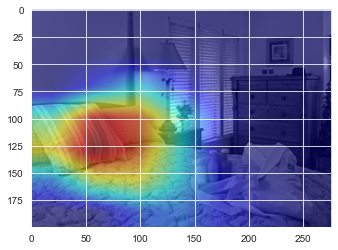

In [67]:
image_filename = "15SceneData/validation/bedroom/image_0003.jpg"
model = load_model(MODEL_SAVES["supervised"])
target_layer = model.features[8]

visualization = generate_score_cam(image_filename, model, target_layer)

plt.imshow(visualization)

In [46]:
models = list(load_model(MODEL_SAVES[model_name]) for model_name in MODEL_SAVES)
# image_list = get_correctly_predicted_images(models, num_images=8)
image_list = get_correctly_predicted_images(models, num_images=8)
del models
image_list

['15SceneData/validation\\highway\\image_0092.jpg',
 '15SceneData/validation\\store\\image_0213.jpg',
 '15SceneData/validation\\suburb\\image_0236.jpg',
 '15SceneData/validation\\tallbuilding\\image_0029.jpg',
 '15SceneData/validation\\opencountry\\image_0113.jpg',
 '15SceneData/validation\\insidecity\\image_0292.jpg',
 '15SceneData/validation\\coast\\image_0169.jpg',
 '15SceneData/validation\\mountain\\image_0088.jpg']

100%|██████████| 24/24 [20:36<00:00, 51.51s/it]


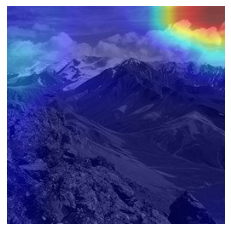

In [47]:
# image_list = ["15SceneData/validation/bedroom/image_0003.jpg"]

model_names = MODEL_SAVES.keys()
# make all combinations of model names and image_list
combinations = list(itertools.product(model_names, image_list))

# for image_filename in image_list:
#     for model_name in MODEL_SAVES:

output_folder = "outputs/explanations"
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.mkdir(output_folder)

for model_name, image_filename in tqdm(combinations, total=len(combinations)):
    model = load_model(MODEL_SAVES[model_name])

    target_layers = {"block1": model.features[1], "block2": model.features[2], "block8": model.features[8]}

    for target_layer_name, target_layer in target_layers.items():


        img_class_name = get_image_class(image_filename)
        img_name = get_image_name(image_filename)

        # save original image
        # image = PIL.Image.open(image_filename)
        # plt.imshow(image)
        output_filename = f"{output_folder}/original_{target_layer_name}_{img_class_name}_{img_name}.png"
        # plt.grid(False)
        # plt.axis('off')
        # plt.savefig(output_filename, bbox_inches='tight', pad_inches=0)
        # copy the image to the output folder
        if os.path.exists(output_filename):
            os.remove(output_filename)
        shutil.copy(image_filename, output_filename)

        visualization = generate_score_cam(image_filename, model, target_layer)

        plt.imshow(visualization)


        # random_int = np.random.randint(100000)
        output_filename = f"{output_folder}/{model_name}_{target_layer_name}_{img_class_name}_{img_name}.png"

        plt.grid(False)
        plt.axis('off')

        plt.savefig(output_filename, bbox_inches='tight', pad_inches=0)


In [17]:
combinations

[('supervised', '15SceneData/validation\\coast\\image_0223.jpg'),
 ('supervised', '15SceneData/validation\\tallbuilding\\image_0153.jpg'),
 ('supervised', '15SceneData/validation\\insidecity\\image_0184.jpg'),
 ('pretext_rotation', '15SceneData/validation\\coast\\image_0223.jpg'),
 ('pretext_rotation', '15SceneData/validation\\tallbuilding\\image_0153.jpg'),
 ('pretext_rotation', '15SceneData/validation\\insidecity\\image_0184.jpg'),
 ('pretext_perturbation', '15SceneData/validation\\coast\\image_0223.jpg'),
 ('pretext_perturbation',
  '15SceneData/validation\\tallbuilding\\image_0153.jpg'),
 ('pretext_perturbation',
  '15SceneData/validation\\insidecity\\image_0184.jpg')]

In [31]:
# get all filenames in the "outputs/explanations" folder
explanation_filenames = []
for root, dirs, files in os.walk("outputs/explanations"):
    for file in files:
        if file.endswith(".png"):
            explanation_filenames.append(file)

block1 = list(filter(lambda x: "block1" in x, explanation_filenames))
block2 = list(filter(lambda x: "block2" in x, explanation_filenames))
block8 = list(filter(lambda x: "block8" in x, explanation_filenames))

In [32]:
def sort_files(files):
    # sort the files such that "original" is first, then supervised, then pretext rotation, then pretext perturbation
    assert len(files) == 4
    sorted_files = [None, None, None, None]

    for file in files:
        if "original" in file:
            sorted_files[0] = file
        elif "supervised" in file:
            sorted_files[1] = file
        elif "pretext_rotation" in file:
            sorted_files[2] = file
        elif "pretext_perturbation" in file:
            sorted_files[3] = file
        else:
            raise Exception("Unknown file")

    return sorted_files

def get_explanation_latex_tabular(block_file_list):
    # group the files by image
    image_groups = {}
    for file in block_file_list:
        img_name = file.split("_")[-1].split(".")[0]
        if img_name not in image_groups:
            image_groups[img_name] = []
        image_groups[img_name].append(file)

    tabular = """
    \\begin{tabular}{lllll}
    \\textbf{Label} & \\textbf{Original} & \\textbf{Supervised} & \\textbf{Rotation pretext} & \\textbf{Perturbation pretext} \\\\ \n
    """

    for img_name, files in image_groups.items():
        # get the image class
        img_class = files[0].split("_")[-3]
        tabular += f"{img_class}"

        sorted_files = sort_files(files)

        # label = sorted_files[0].split("_")[-3]
        #
        # tabular += label

        for file in sorted_files:
            overleaf_filename = f"img/explanations/{file}"
            tabular += " & \\includegraphics[width=0.2\\textwidth,valign=m]{" + overleaf_filename + "}"

        tabular += " \\\\ \n"

    tabular += "\\end{tabular}"

    return tabular

In [36]:
import pyperclip
tabular_block = get_explanation_latex_tabular(block8)
print(tabular_block)
pyperclip.copy(tabular_block)


    \begin{tabular}{lllll}
    \textbf{Label} & \textbf{Original} & \textbf{Supervised} & \textbf{Rotation pretext} & \textbf{Perturbation pretext} \\ 

    bedroom & \includegraphics[width=0.2\textwidth,valign=m]{img/explanations/original_block8_bedroom_image_0077.png} & \includegraphics[width=0.2\textwidth,valign=m]{img/explanations/supervised_block8_bedroom_image_0077.png} & \includegraphics[width=0.2\textwidth,valign=m]{img/explanations/pretext_rotation_block8_bedroom_image_0077.png} & \includegraphics[width=0.2\textwidth,valign=m]{img/explanations/pretext_perturbation_block8_bedroom_image_0077.png} \\ 
forest & \includegraphics[width=0.2\textwidth,valign=m]{img/explanations/original_block8_forest_image_0241.png} & \includegraphics[width=0.2\textwidth,valign=m]{img/explanations/supervised_block8_forest_image_0241.png} & \includegraphics[width=0.2\textwidth,valign=m]{img/explanations/pretext_rotation_block8_forest_image_0241.png} & \includegraphics[width=0.2\textwidth,valign=m]{img

tensor([0])


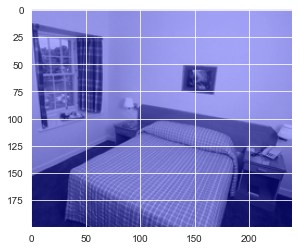

In [42]:
model = load_model(MODEL_SAVES["pretext_rotation"])
image_filename = "15SceneData/validation/bedroom/image_0077.jpg"
for image, _ in get_explanation_data_loader(image_filename):

    prediction = model(image)

    prediction_result = torch.argmax(prediction, dim=1)

    print(prediction_result)

prediction

viz = generate_score_cam(image_filename, model, model.features[8])
plt.imshow(viz)


## Interpretation
For the interpretation part, you should utilize the model inversion method proposed
in [3]. This model inversion technique is part of the last exercise session.

In [ ]:
model = load_model(MODEL_SAVES["supervised"])



### practicum version

In [15]:
from RegularizedUnitSpecificImageGeneration import RegularizedClassSpecificImageGeneration
import numpy as np

# select 5 classes randomly
# target_classes = np.random.choice(LABELS, 5, replace=False)
# target_classes = ["street", "forest", "opencountry", "mountain", "tallbuilding"]
# target_classes = ["bedroom"]


def get_interpretation(model, output_dir, idx, silu=True,plot=True):
    # for target_class in target_classes:
    # print(f"Generating interpretation for class {target_class}")
    # target_class_idx = LABELS.index(target_class)

    csig = RegularizedClassSpecificImageGeneration(model, idx, output_dir=output_dir, grayscale=True, silu_output=silu, n_outputs=10)

    # csig.generate(iterations=150, blur_freq=6, blur_rad=0.1, wd=0.0005)
    csig.generate(blur_freq=5, blur_rad=0.8, wd = 0.00005, iterations=30, initial_learning_rate=0.00005)

    if plot:
        loss_list = csig.loss_list
        plt.plot(loss_list)
        plt.show()

grayscale is deprecated
Use cuda: True
Iteration: 3 Loss 1158.65
Iteration: 6 Loss -77941.98
Iteration: 10 Loss 1181.43
Iteration: 13 Loss -107.75
Iteration: 16 Loss 390.47
Iteration: 20 Loss 39549.81
Iteration: 23 Loss -6338.03
Iteration: 26 Loss 10972.33


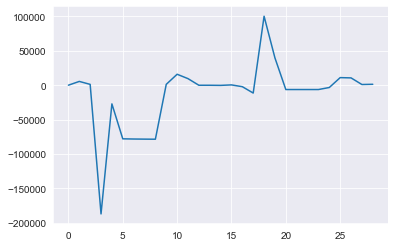

In [16]:
model = load_model(MODEL_SAVES["supervised"])
get_interpretation(model, output_dir="outputs/interpretations/supervised", idx=70)

In [11]:
model = load_model(MODEL_SAVES["supervised"])
get_interpretation(model, output_dir="outputs/interpretations/supervised2")

TypeError: get_interpretation() missing 1 required positional argument: 'idx'

In [15]:
global HYPEROPT_MODEL_PARAMS
HYPEROPT_MODEL_PARAMS = {
    "rcsig": None,
    "best_loss": np.inf,
    "best_parameter_set": None,
    "all_results": [],
}


# csig = RegularizedClassSpecificImageGeneration(model, target_class_idx, output_dir=output_dir, grayscale=False)
#
#         # model.train(True)
#
#         with torch.enable_grad(): # it's not calculating the grads for all models except for efficientnet, no idea whats the difference, since only the image has grads and the model is frozen. Probably pytorch version issues.
#             csig.generate(iterations=1000)

# model, target_class_idx, output_dir=output_dir, grayscale=True

def objective_invert(params):
    global HYPEROPT_MODEL_PARAMS
    rcsig = HYPEROPT_MODEL_PARAMS["rcsig"]
    best_loss = HYPEROPT_MODEL_PARAMS["best_loss"]

    # blur_freq=4, blur_rad=1, wd=0.0001, clipping_value=0.1

    blur_freq = int(params['blur_freq'])
    blur_rad = params['blur_rad']
    wd = params['wd']
    clipping_value = params['clipping_value']
    initial_learning_rate = params['initial_learning_rate']

    # print(f"blur_freq: {blur_freq}, blur_rad: {blur_rad}, wd: {wd}, clipping_value: {clipping_value}")

    loss = rcsig.generate(iterations=150, blur_freq=blur_freq, blur_rad=blur_rad, wd=wd, clipping_value=clipping_value,
                          initial_learning_rate=initial_learning_rate)

    parameter_set = (blur_freq, blur_rad, wd, clipping_value, initial_learning_rate)
    if loss < best_loss:
        HYPEROPT_MODEL_PARAMS["best_loss"] = loss
        HYPEROPT_MODEL_PARAMS["best_parameter_set"] = parameter_set

        print(f"New best parameter set: {parameter_set}, with loss {loss}")

    HYPEROPT_MODEL_PARAMS["all_results"].append((parameter_set, loss))

    return {'loss': loss, 'status': STATUS_OK}


def train_hyperopt(model, target_class, descr, trials=None, max_evals=100):
    output_dir = f"outputs/interpretations/{descr}"

    global HYPEROPT_MODEL_PARAMS
    target_class_idx = LABELS.index(target_class)
    csig = RegularizedClassSpecificImageGeneration(model, target_class_idx, output_dir=output_dir, verbose=False,
                                                   n_outputs=3)
    HYPEROPT_MODEL_PARAMS["rcsig"] = csig
    HYPEROPT_MODEL_PARAMS["best_loss"] = np.inf
    HYPEROPT_MODEL_PARAMS["best_parameter_set"] = None
    HYPEROPT_MODEL_PARAMS["all_results"] = []

    # blur_freq=4, blur_rad=1, wd=0.0001, clipping_value=0.1

    print(f"Starting hyperopt for {descr} at {time.strftime('%Y%m%d_%H%M%S')}")

    space = {
        'blur_freq': hp.quniform('blur_freq', 2, 10, 1),
        'blur_rad': hp.uniform('blur_rad', 0.5, 2),
        'wd': hp.loguniform('wd', np.log(0.00001), np.log(10)),
        'clipping_value': hp.uniform('clipping_value', 0.01, 0.2),
        'initial_learning_rate': hp.loguniform('initial_learning_rate', np.log(0.000001), np.log(10)),
    }

    start = time.time()
    trials = Trials() if trials is None else trials
    best = fmin(
        objective_invert,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials
    )

    print(
        f"Best parameter set: {HYPEROPT_MODEL_PARAMS['best_parameter_set']}, with loss {HYPEROPT_MODEL_PARAMS['best_loss']}")

    print(f"Hyperopt took {time.time() - start} seconds")

    timestr = time.strftime("%Y%m%d_%H%M%S")
    filename = f"outputs/hyperopt_{descr}_{timestr}"
    pickle.dump(trials, open(f"{filename}_trials.pickle", "wb"))
    pickle.dump(HYPEROPT_MODEL_PARAMS["all_results"], open(f"{filename}_all.pickle", "wb"))
    # trials = pickle.load(open("trials.p", "rb")) # Pass this to Hyperopt during the next training run.

    return best, trials


# import Line2D
from matplotlib.lines import Line2D


# def plot_paramsearch(results):
#     # plot lr logarithmicly and loss using seaborn
#     lrs = [param_set[0] for param_set, log in results]
#     losses = [log.get_best_loss() for param_set, log in results]
#
#     df = pd.DataFrame({"lr": lrs, "loss": losses})
#
#     sns.scatterplot(data=df, x="lr", y="loss")
#     plt.xscale("log")
#
#     plt.show()
#
#     # plot epoch and lrs with the loss as hue
#     lrs = [param_set[0] for param_set, log in results]
#     losses = [log.get_best_loss() for param_set, log in results]
#     trial = range(len(losses))
#
#     df = pd.DataFrame({"lr": lrs, "loss": losses, "trial": trial})
#
#     # hue palette should be green for low loss and red for high loss
#     palette = sns.color_palette("RdYlGn", len(df["loss"]))
#     palette = palette[::-1]  # reverse the palette
#     sns.scatterplot(data=df, x="trial", y="lr", hue="loss", palette=palette)
#     # since loss is a float, create a simple legend instead of per value
#     legend_elements = [Line2D([0], [0], marker='o', color='w', label='loss',
#                               markerfacecolor=palette[0], markersize=10),
#                        Line2D([0], [0], marker='o', color='w', label='loss',
#                               markerfacecolor=palette[-1], markersize=10)]
#     plt.legend(handles=legend_elements, labels=["low loss", "high loss"])
#
#     plt.yscale("log")
#
#     plt.show()

In [18]:
model = load_model(MODEL_SAVES["supervised"])
# get_interpretation(model, output_dir="outputs/interpretations/pretext_rotation")
best, trials = train_hyperopt(model, "bedroom", "supervised")

results = HYPEROPT_MODEL_PARAMS["all_results"]
results

Starting hyperopt for supervised at 20230823_222551
New best parameter set: (9, 0.5750528164850649, 0.008081494409884753, 0.12403494509507863), with loss 5525.34228515625
New best parameter set: (8, 1.3053226533359104, 0.9247470982983429, 0.0655766362450525), with loss 1987.636474609375
New best parameter set: (6, 1.1492301458347747, 0.0002991227136629876, 0.04784374577626908), with loss 687.5396728515625
New best parameter set: (4, 1.2531575233436798, 0.001531863244849607, 0.013435779660430006), with loss 579.8975830078125
New best parameter set: (4, 1.4627816569503655, 0.0014646353223915951, 0.022461821750974394), with loss 110.17745971679688
New best parameter set: (5, 1.4541819558983804, 0.0011362300289687788, 0.10891385566073061), with loss 73.92594909667969
New best parameter set: (4, 1.335813838681895, 1.8423818856073158e-05, 0.010000159181609871), with loss 10.087170600891113
New best parameter set: (4, 1.5660105546150545, 0.1927864222686215, 0.028071465325270877), with loss 1.

[((9, 0.5750528164850649, 0.008081494409884753, 0.12403494509507863),
  array(5525.3423, dtype=float32)),
 ((8, 1.3053226533359104, 0.9247470982983429, 0.0655766362450525),
  array(1987.6365, dtype=float32)),
 ((7, 1.4626421416510602, 2.0639975687474085e-05, 0.19749076097194282),
  array(3962.9592, dtype=float32)),
 ((3, 1.6925199317834165, 0.001928708019483845, 0.07508139156165088),
  array(2832.639, dtype=float32)),
 ((7, 1.9095380912845874, 1.9806091243364747, 0.0818445121022254),
  array(32928.492, dtype=float32)),
 ((4, 0.9529753646362022, 0.0006024361430393589, 0.10460362492096206),
  array(24004.18, dtype=float32)),
 ((9, 1.5863347670264782, 0.09046932972280146, 0.18784541050624226),
  array(18609.621, dtype=float32)),
 ((6, 1.1492301458347747, 0.0002991227136629876, 0.04784374577626908),
  array(687.5397, dtype=float32)),
 ((4, 1.2531575233436798, 0.001531863244849607, 0.013435779660430006),
  array(579.8976, dtype=float32)),
 ((4, 1.4627816569503655, 0.0014646353223915951, 0.0

In [22]:
best, trials = train_hyperopt(model, "bedroom", "supervised", trials=trials, max_evals=500)

Starting hyperopt for supervised at 20230823_224234
 20%|██        | 100/500 [00:00<?, ?trial/s, best loss=?]

C:\Users\arnod\PycharmProjects\ANN-Self-Supervised-Scene-Classification\RegularizedUnitSpecificImageGeneration.py:102: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(



New best parameter set: (2, 1.8405173498092502, 0.1635097969815707, 0.02942598676106041), with loss 1.3147927522659302
New best parameter set: (2, 1.850778663471686, 0.10710149906054271, 0.03618144366580273), with loss 0.6310839653015137
New best parameter set: (2, 1.8277612712066287, 0.13089153471070825, 0.010505528224517929), with loss 0.4662163555622101
New best parameter set: (3, 1.5998873631245303, 0.14318165108397604, 0.17378730296110517), with loss 0.45469483733177185
New best parameter set: (2, 1.2883602733785087, 0.16831499417015452, 0.1014161789739968), with loss 0.07833482325077057
 50%|█████     | 250/500 [21:19<35:32,  8.53s/trial, best loss: 0.07833482325077057]


KeyboardInterrupt: 

```
New best parameter set: (9, 0.5750528164850649, 0.008081494409884753, 0.12403494509507863), with loss 5525.34228515625
New best parameter set: (8, 1.3053226533359104, 0.9247470982983429, 0.0655766362450525), with loss 1987.636474609375
New best parameter set: (6, 1.1492301458347747, 0.0002991227136629876, 0.04784374577626908), with loss 687.5396728515625
New best parameter set: (4, 1.2531575233436798, 0.001531863244849607, 0.013435779660430006), with loss 579.8975830078125
New best parameter set: (4, 1.4627816569503655, 0.0014646353223915951, 0.022461821750974394), with loss 110.17745971679688
New best parameter set: (5, 1.4541819558983804, 0.0011362300289687788, 0.10891385566073061), with loss 73.92594909667969
New best parameter set: (4, 1.335813838681895, 1.8423818856073158e-05, 0.010000159181609871), with loss 10.087170600891113
New best parameter set: (4, 1.5660105546150545, 0.1927864222686215, 0.028071465325270877), with loss 1.4317988157272339
New best parameter set: (3, 1.4964813562055752, 0.18945643282995986, 0.02904955610600472), with loss 1.2151890993118286
New best parameter set: (2, 1.8772553495835926, 0.20378107431236597, 0.032004148694054865), with loss 0.4445255994796753
100%|██████████| 100/100 [13:00<00:00,  7.80s/trial, best loss: 0.4445255994796753]
Best parameter set: (2, 1.8772553495835926, 0.20378107431236597, 0.032004148694054865), with loss 0.4445255994796753
Hyperopt took 780.2367970943451 seconds
======
New best parameter set: (2, 1.8405173498092502, 0.1635097969815707, 0.02942598676106041), with loss 1.3147927522659302
New best parameter set: (2, 1.850778663471686, 0.10710149906054271, 0.03618144366580273), with loss 0.6310839653015137
New best parameter set: (2, 1.8277612712066287, 0.13089153471070825, 0.010505528224517929), with loss 0.4662163555622101
New best parameter set: (3, 1.5998873631245303, 0.14318165108397604, 0.17378730296110517), with loss 0.45469483733177185
New best parameter set: (2, 1.2883602733785087, 0.16831499417015452, 0.1014161789739968), with loss 0.07833482325077057
 50%|█████     | 250/500 [21:19<35:32,  8.53s/trial, best loss: 0.07833482325077057]
 ```

In [16]:
model = load_model(MODEL_SAVES["supervised"])
best, trials = train_hyperopt(model, "bedroom", "supervised")
results = HYPEROPT_MODEL_PARAMS["all_results"]
results

Starting hyperopt for supervised at 20230823_231126
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\arnod\PycharmProjects\ANN-Self-Supervised-Scene-Classification\RegularizedUnitSpecificImageGeneration.py:102: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(



New best parameter set: (9, 0.6705441051120873, 5.552543684126183e-05, 0.049726188093099075, 0.00011657765568890357), with loss 39.6075553894043
New best parameter set: (9, 1.5482301802620735, 0.0036634517314775975, 0.05138270807998281, 0.00011607664358628816), with loss 1.143173098564148
New best parameter set: (9, 1.0653273670324626, 4.6236064722525214e-05, 0.110654705557262, 0.20968635929365842), with loss 0.5335875749588013
New best parameter set: (8, 1.2008550924924843, 0.0010902063582285467, 0.07909510063260475, 0.28133178966905936), with loss 0.2592199742794037
New best parameter set: (10, 1.1126719334316686, 8.329688594903796e-05, 0.06585414526603563, 5.7743173054393074e-05), with loss -0.24226932227611542
New best parameter set: (6, 1.1578952123521815, 0.015343986644300483, 0.023833263747300985, 2.6244996138868962e-06), with loss -0.3305676579475403
New best parameter set: (7, 1.9689644763905279, 0.42266872979191655, 0.027541552367528623, 0.10741372851457895), with loss -10.04

[((9,
   0.6705441051120873,
   5.552543684126183e-05,
   0.049726188093099075,
   0.00011657765568890357),
  array(39.607555, dtype=float32)),
 ((9,
   1.5482301802620735,
   0.0036634517314775975,
   0.05138270807998281,
   0.00011607664358628816),
  array(1.1431731, dtype=float32)),
 ((9,
   1.2316863411320615,
   0.00014009588394758068,
   0.19220385631836115,
   0.00037447892457173073),
  array(1.1431731, dtype=float32)),
 ((5,
   1.3994021571378084,
   0.002088477849662893,
   0.02807903872819479,
   2.4115423536617204e-05),
  array(1.1431731, dtype=float32)),
 ((6,
   0.7053272940580788,
   8.115767127836106e-05,
   0.012859114677282846,
   0.0028495490272674815),
  array(1.1431731, dtype=float32)),
 ((9,
   1.0653273670324626,
   4.6236064722525214e-05,
   0.110654705557262,
   0.20968635929365842),
  array(0.5335876, dtype=float32)),
 ((9,
   0.641934407418062,
   5.581622296584305e-05,
   0.08028517582636839,
   1.1309467136494079e-06),
  array(0.54475266, dtype=float32)),
 (

In [17]:
best, trials = train_hyperopt(model, "bedroom", "supervised", trials=trials, max_evals=200)

Starting hyperopt for supervised at 20230823_232435
New best parameter set: (5, 1.7370313392851786, 0.034174775022743485, 0.03601634941467828, 0.4144142540769391), with loss 8.059386253356934
New best parameter set: (8, 1.9678494906428539, 0.4273619746504256, 0.0825190546455869, 1.3527414837689866), with loss 0.5057467818260193
New best parameter set: (2, 1.3758652281615587, 0.0032007540951090843, 0.09227575594889911, 0.012460560084004486), with loss -0.1816117912530899
New best parameter set: (4, 1.3111481961179323, 0.002037213813830894, 0.04311771880136412, 0.1085994733514544), with loss -0.1983805000782013
New best parameter set: (8, 1.9994873548303687, 0.5973289907413888, 0.05526040361410806, 0.8160384738611216), with loss -0.3677794337272644
New best parameter set: (2, 0.9628972212958704, 0.17018873510415045, 0.11199471101283257, 0.21803391617866777), with loss -19.109500885009766
New best parameter set: (2, 0.9498656688388663, 3.1497111332439385, 0.13440912855927367, 0.0003360995

Starting hyperopt for supervised at 20230823_232435
New best parameter set: (5, 1.7370313392851786, 0.034174775022743485, 0.03601634941467828, 0.4144142540769391), with loss 8.059386253356934
New best parameter set: (8, 1.9678494906428539, 0.4273619746504256, 0.0825190546455869, 1.3527414837689866), with loss 0.5057467818260193
New best parameter set: (2, 1.3758652281615587, 0.0032007540951090843, 0.09227575594889911, 0.012460560084004486), with loss -0.1816117912530899
New best parameter set: (4, 1.3111481961179323, 0.002037213813830894, 0.04311771880136412, 0.1085994733514544), with loss -0.1983805000782013
New best parameter set: (8, 1.9994873548303687, 0.5973289907413888, 0.05526040361410806, 0.8160384738611216), with loss -0.3677794337272644
New best parameter set: (2, 0.9628972212958704, 0.17018873510415045, 0.11199471101283257, 0.21803391617866777), with loss -19.109500885009766
New best parameter set: (2, 0.9498656688388663, 3.1497111332439385, 0.13440912855927367, 0.00033609959404661357), with loss -24.544193267822266
100%|██████████| 200/200 [13:20<00:00,  8.01s/trial, best loss: -24.544193267822266]
Best parameter set: (2, 0.9498656688388663, 3.1497111332439385, 0.13440912855927367, 0.00033609959404661357), with loss -24.544193267822266
Hyperopt took 800.5681891441345 seconds

In [18]:
best, trials = train_hyperopt(model, "bedroom", "supervised", trials=trials, max_evals=20000)

Starting hyperopt for supervised at 20230823_234544
New best parameter set: (4, 0.9835600534500643, 0.0014837401182459433, 0.1090343508409016, 1.7185359432214595e-05), with loss 0.8340587615966797
  1%|          | 206/20000 [05:02<277:12:43, 50.42s/trial, best loss: -24.544193267822266]  


KeyboardInterrupt: 

In [19]:
model = load_model(MODEL_SAVES["supervised"])

# For the interpretation part, select five filters from the convolutional layer in the latest
# block (i.e., torchvision.models.eff icientnet b0.features[8]) with the highest summation of its weights. Then, run the model inversion algorithm on the output of activation layer (i.e., SiLu layer torchvision.models.eff icientnet b0.features[8][2]) related
# to the selected filters. The algorithm should generate a synthetic image illustrating
# the features that maximize the aggregated activations of the feature map outputs from
# the SiLu function (i.e., torchvision.models.eff icientnet b0.features[8][2])

# model consists of the features and the classifier, only select the features as new model
model_f = model.features

# Get the five filters with the highest summation of weights
# latest_block = model.features[8]
latest_block = model_f[8]
weights = latest_block[0].weight.data.numpy() # todo: make sure I am selecting the convolutional layer
# weights has shape (1280, 320, 1, 1); sum to get the sum of weights for each filter (resulting in a vector of length 1280)
sum_weights = np.sum(weights, axis=1)
print(sum_weights.shape)
# 1280x1x1, so we can just flatten it
sum_weights = sum_weights.flatten()
print(sum_weights.shape)
top_indices = np.argsort(sum_weights)[-5:]
# print top_indices with their corresponding sum_weights
for idx in top_indices:
    print(f"Filter {idx} has sum of weights {sum_weights[idx]}")

(1280, 1, 1)
(1280,)
Filter 768 has sum of weights 3.0797011852264404
Filter 833 has sum of weights 3.1215085983276367
Filter 944 has sum of weights 3.612844705581665
Filter 1250 has sum of weights 3.785414695739746
Filter 70 has sum of weights 4.186988353729248


In [20]:
for idx in top_indices:
    get_interpretation(model, output_dir="outputs/interpretations/supervised", idx=idx)
    break

grayscale is deprecated
Use cuda: True
Iteration: 1 Loss -61320.97


C:\Users\arnod\PycharmProjects\ANN-Self-Supervised-Scene-Classification\RegularizedUnitSpecificImageGeneration.py:111: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(


Iteration: 2 Loss -4900.05
Iteration: 3 Loss -0.00
Iteration: 4 Loss -0.00
Iteration: 5 Loss -0.00
Iteration: 6 Loss -0.00
Iteration: 7 Loss -0.00
Iteration: 8 Loss -0.00
Iteration: 9 Loss -0.00
Iteration: 10 Loss -0.00
Iteration: 11 Loss -0.00
Iteration: 12 Loss -0.00
Iteration: 13 Loss -0.00
Iteration: 14 Loss -0.00
Iteration: 15 Loss -0.00
Iteration: 16 Loss -0.00
Iteration: 17 Loss -0.00
Iteration: 18 Loss -0.00
Iteration: 19 Loss -0.00
Iteration: 20 Loss -0.00
Iteration: 21 Loss -0.00
Iteration: 22 Loss -0.00
Iteration: 23 Loss -0.00
Iteration: 24 Loss -0.00
Iteration: 25 Loss -0.00
Iteration: 26 Loss -0.00
Iteration: 27 Loss -0.00
Iteration: 28 Loss -0.00
Iteration: 29 Loss -0.00
Iteration: 30 Loss -0.00
Iteration: 31 Loss -0.00
Iteration: 32 Loss -0.00
Iteration: 33 Loss -0.00
Iteration: 34 Loss -0.00
Iteration: 35 Loss -0.00
Iteration: 36 Loss -0.00
Iteration: 37 Loss -0.00
Iteration: 38 Loss -0.00
Iteration: 39 Loss -0.00
Iteration: 40 Loss -0.00
Iteration: 41 Loss -0.00
Itera

KeyboardInterrupt: 

In [63]:
# model = load_model(MODEL_SAVES["supervised"])
image_filename = "15SceneData/validation/bedroom/image_0077.jpg"

def get_image_output(model, image_filename):
    for image, _ in get_explanation_data_loader(image_filename):
        output = model(image)
        # prediction_result = torch.argmax(prediction, dim=1)
        return output


In [68]:
model = load_model(MODEL_SAVES["supervised"])
get_image_output(model, image_filename).shape

torch.Size([1, 15])

In [66]:
# add an aggregation layer to the model, which just sums the output of the 7x7 feature map (no weights) for
get_image_output(model_f, image_filename)

torch.Size([1, 1280, 7, 7])

In [67]:
print(model_f)

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [69]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [60]:
get_interpretation(model_f, output_dir="outputs/interpretations/supervised", idx=70)

Generating interpretation for class bedroom
grayscale is deprecated
Use cuda: True


RuntimeError: grad can be implicitly created only for scalar outputs

New best parameter set: (3, 1.7222720407447347, 0.8359901289962085, 0.026445047011242624, 0.11567376765761597), with loss -13.263970375061035
100%|██████████| 100/100 [12:42<00:00,  7.62s/trial, best loss: -13.263970375061035]
Best parameter set: (3, 1.7222720407447347, 0.8359901289962085, 0.026445047011242624, 0.11567376765761597), with loss -13.263970375061035
Hyperopt took 762.171389579773 seconds

In [ ]:
model = load_model(MODEL_SAVES["pretext_perturbation"])
get_interpretation(model, output_dir="outputs/interpretations/pretext_perturbation")

In [36]:
model_efficient_b0 = models.efficientnet_b0(weights='IMAGENET1K_V1')
get_interpretation(model_efficient_b0, output_dir="outputs/interpretations/efficient_b0")

Generating interpretation for class street
Iteration: 111 Loss 0.26
Iteration: 222 Loss -0.18
Iteration: 333 Loss 0.24
Iteration: 444 Loss -0.66
Iteration: 555 Loss -0.68
Iteration: 666 Loss -0.27
Iteration: 777 Loss -0.20
Iteration: 888 Loss -0.78
Generating interpretation for class forest
Iteration: 111 Loss -0.13
Iteration: 222 Loss -0.42
Iteration: 333 Loss 0.01
Iteration: 444 Loss -0.88
Iteration: 555 Loss -0.61
Iteration: 666 Loss -0.97
Iteration: 777 Loss -0.63
Iteration: 888 Loss -0.79
Generating interpretation for class opencountry
Iteration: 111 Loss -0.30


KeyboardInterrupt: 

# Evaluation

In [17]:
def evaluation_report(model, loader):
    """
    :param model: the model to be evaluated
    :param loader: the loader to be used for evaluation
    :return: the classification report and the confusion matrix
    """
    y_true = []
    y_pred = []

    for images, labels in loader:
        y_true.extend(labels.numpy())
        predictions = model(images)
        predictions = torch.argmax(predictions, dim=1)
        y_pred.extend(predictions.numpy())

    return classification_report(y_true, y_pred, target_names=LABELS), confusion_matrix(y_true, y_pred)

In [ ]:



def explain_predictions(model, val_batch):
    """
    Takesimages from the validation set and generates a Score-CAM explanation for each of them.
    :param model: the model to be explained
    :param val_batch: the validation set images and labels to explain
    """

    explanations = []

    images = val_batch[0]
    labels = val_batch[1]

    for image, label in zip(images, labels):
        # get the explanation for the final layr
        target_layer = model._modules.get('classifier')  # tODO: dit of model.classifier[-1]
        cam_extractor = ScoreCAM(model=model, target_layer=target_layer)

        # get the explanation for the image
        explanation = cam_extractor(image, target_category=label)
        explanations.append(explanation)

        # create plots, where each row contais the original image, the heatmap and the heatmap overlayed on the original image
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image.permute(1, 2, 0))
        ax[0].set_title("Original image")

        ax[1].imshow(explanation.squeeze().permute(1, 2, 0))
        ax[1].set_title("Heatmap")

        ax[2].imshow(image.permute(1, 2, 0))
        ax[2].imshow(explanation.squeeze().permute(1, 2, 0), alpha=0.5)
        ax[2].set_title("Heatmap overlayed on the original image")


images_to_explain = next(iter(val_loader))[0][:3]

In [18]:
for model_name in MODEL_SAVES:
    model = load_model(MODEL_SAVES[model_name])
    report, confusion = evaluation_report(model, val_loader)
    print(f"Model: {model_name}")
    print(report)
    print(confusion)

    # print latex table of the confusion matrix
    table = pd.DataFrame(confusion, index=LABELS, columns=LABELS)
    print(table.to_latex())

    print("\n\n")



Model: supervised
              precision    recall  f1-score   support

     bedroom       0.86      0.88      0.87       116
       coast       0.90      0.97      0.93       260
      forest       0.94      0.96      0.95       228
     highway       0.93      0.96      0.95       160
  industrial       0.93      0.90      0.91       211
  insidecity       0.91      0.93      0.92       208
     kitchen       0.93      0.95      0.94       110
  livingroom       0.91      0.90      0.91       189
    mountain       0.96      0.95      0.95       274
      office       0.96      0.97      0.97       115
 opencountry       0.93      0.87      0.90       310
       store       0.98      0.96      0.97       215
      street       0.95      0.93      0.94       192
      suburb       0.98      1.00      0.99       141
tallbuilding       0.97      0.95      0.96       256

    accuracy                           0.94      2985
   macro avg       0.94      0.94      0.94      2985
weighted

C:\Users\arnod\AppData\Local\Temp/ipykernel_18036/2072257027.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


Model: pretext_rotation
              precision    recall  f1-score   support

     bedroom       0.64      0.75      0.69       116
       coast       0.76      0.74      0.75       260
      forest       0.80      0.74      0.77       228
     highway       0.70      0.80      0.75       160
  industrial       0.83      0.40      0.54       211
  insidecity       0.78      0.63      0.70       208
     kitchen       0.43      0.65      0.52       110
  livingroom       0.69      0.50      0.58       189
    mountain       0.77      0.74      0.76       274
      office       0.62      0.73      0.67       115
 opencountry       0.62      0.71      0.66       310
       store       0.71      0.74      0.73       215
      street       0.73      0.85      0.78       192
      suburb       0.77      0.96      0.85       141
tallbuilding       0.82      0.82      0.82       256

    accuracy                           0.71      2985
   macro avg       0.71      0.72      0.70      2985
we

C:\Users\arnod\AppData\Local\Temp/ipykernel_18036/2072257027.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


Model: pretext_perturbation
              precision    recall  f1-score   support

     bedroom       0.59      0.79      0.68       116
       coast       0.67      0.58      0.62       260
      forest       0.73      0.70      0.71       228
     highway       0.66      0.79      0.72       160
  industrial       0.77      0.55      0.64       211
  insidecity       0.71      0.62      0.66       208
     kitchen       0.62      0.72      0.67       110
  livingroom       0.78      0.56      0.65       189
    mountain       0.68      0.74      0.71       274
      office       0.70      0.90      0.79       115
 opencountry       0.56      0.55      0.56       310
       store       0.85      0.80      0.82       215
      street       0.69      0.76      0.72       192
      suburb       0.77      0.92      0.84       141
tallbuilding       0.76      0.79      0.78       256

    accuracy                           0.70      2985
   macro avg       0.70      0.72      0.70      298

C:\Users\arnod\AppData\Local\Temp/ipykernel_18036/2072257027.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())
